# Анализ клиентской базы сети фитнес-центров

Проблема бизнеса — отток клиентов.

Цель исследования: на основе данных клиентских анкет провести анализ и подготовить план действий по удержанию клиентов.

Задачи:
* Провести исследовательский анализ данных (EDA);
* Построить модель прогноза оттока клиентов;
* Выделить целевые группы клиентов;
* Разработать рекомендации для стратегии взаимодействия с клиентами и их удержания.

## Необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Исследовательский анализ данных

In [3]:
data = pd.read_csv('gym_churn.csv')

In [4]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


In [8]:
print('Количество оставшихся клиентов:', len(data.query('Churn == 0')))
print('Количество ушедших клиентов:', len(data.query('Churn == 1')))

Количество оставшихся клиентов: 2939
Количество ушедших клиентов: 1061


Первичный обзор данных показывает, что мы имеем данные о 4 000 посетителей фитнес-клуба. Пропуски и дубликаты в таблице отсутствуют. Все переменные записаны в числовом формате (float64 и int64). Переменные gender, Near_Location, Partner, Promo_friends, Phone, Group_visits и Churn - бинарные, для которых значение 0 соответствует отсутствию признака, 1 - наличию признака. 

Согласно описательным статистикам, средний возраст посетителей - 29 лет. Большинство клиентов живут или работают в районе фитнес-центра и не являются участниками акции "приведи друга" (предположительно, выбор фитнес-центра основан на удобстве расположения). Ходят в зал в среднем уже 3 месяца около 2 раз в неделю. Предпочитают покупать абонемент на 1 месяц и тратят на прочие услуги в большинстве случаев до 200 р. Переменная трат (Avg_additional_charges_total) имеет разброс данных: стандартное отклонение составляет 96 при среднем значении в 146.

Доля оттока (ушедших клиентов) составляет 26%. Рассмотрим переменные в разбивке значений на ушедших и оставшихся пользователей.

In [10]:
data.groupby('Churn').agg(['mean', 'median']).T

Churn                                              0           1
gender                            mean      0.510037    0.510839
                                  median    1.000000    1.000000
Near_Location                     mean      0.873086    0.768143
                                  median    1.000000    1.000000
Partner                           mean      0.534195    0.355325
                                  median    1.000000    0.000000
Promo_friends                     mean      0.353522    0.183789
                                  median    0.000000    0.000000
Phone                             mean      0.903709    0.902922
                                  median    1.000000    1.000000
Contract_period                   mean      5.747193    1.728558
                                  median    6.000000    1.000000
Group_visits                      mean      0.464103    0.268615
                                  median    0.000000    0.000000
Age                               mean     29.976523   26.989632
                                  median   30.000000   27.000000
Avg_additional_charges_total      mean    158.445715  115.082899
                                  median  149.881171  103.814686
Month_to_end_contract             mean      5.283089    1.662582
                                  median    6.000000    1.000000
Lifetime                          mean      4.711807    0.990575
                                  median    4.000000    1.000000
Avg_class_frequency_total         mean      2.024876    1.474995
                                  median    2.043252    1.491187
Avg_class_frequency_current_month mean      2.027882    1.044546
                                  median    2.046697    0.979445

In [11]:
#бинарные переменные
binar_features = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']

#числовые переменные
num_features = (
    ['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 
     'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
)

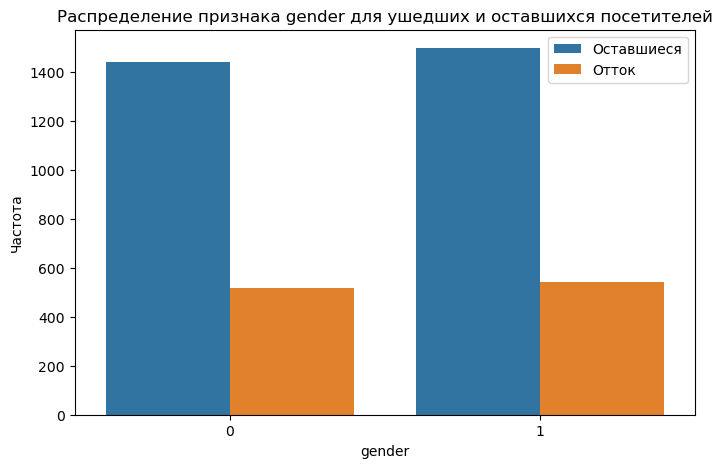

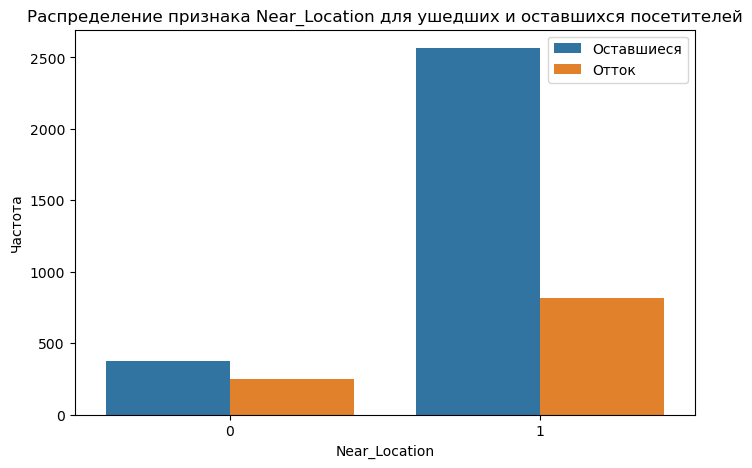

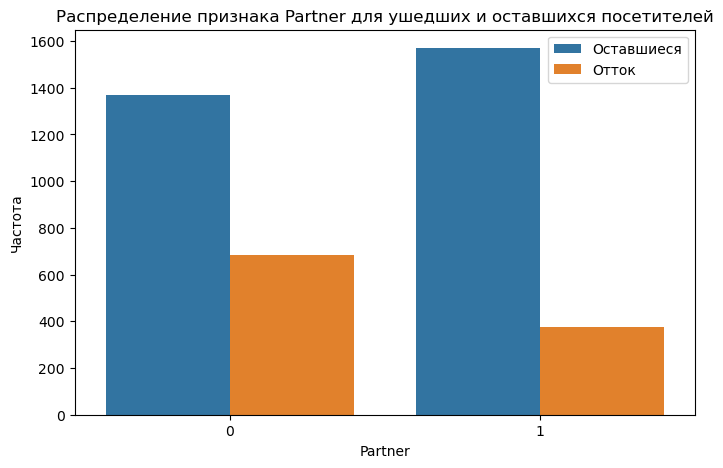

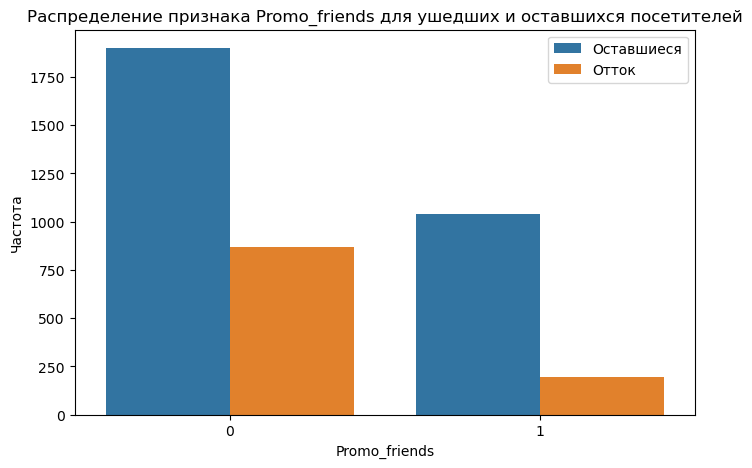

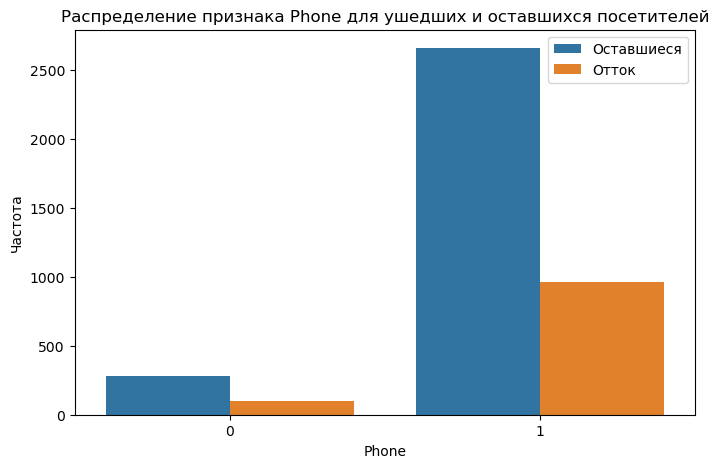

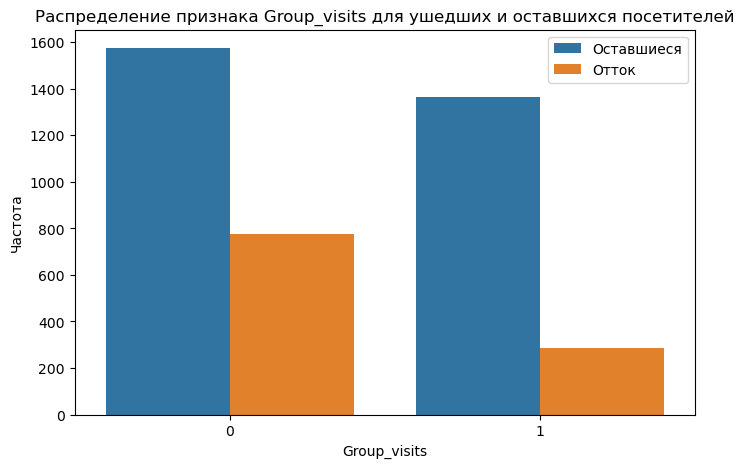

In [13]:
for feature in binar_features:
    sns.color_palette("icefire", as_cmap=True)
    plt.figure(figsize=(8, 5))
    sns.countplot(x=data[feature], hue='Churn', data=data)
    plt.title('Распределение признака {} для ушедших и оставшихся посетителей'.format(feature))
    plt.legend(['Оставшиеся', 'Отток'])
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

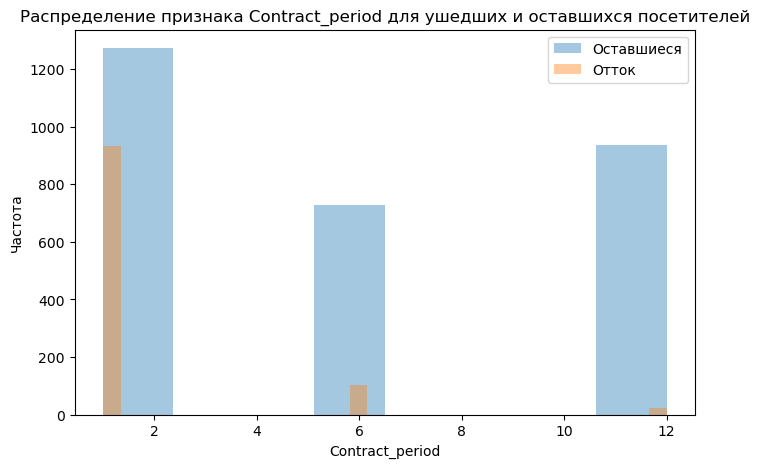

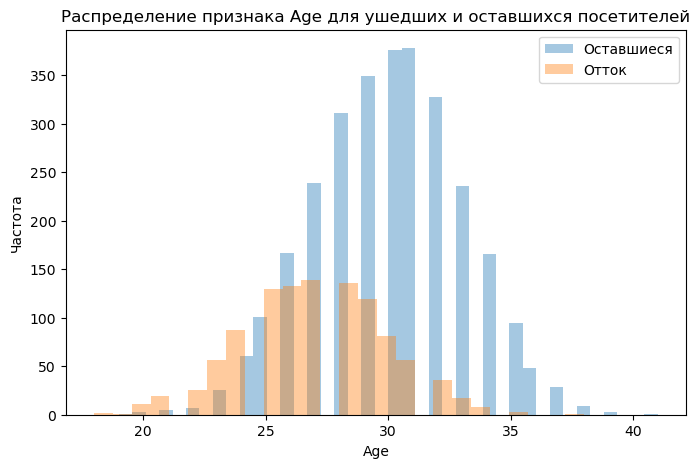

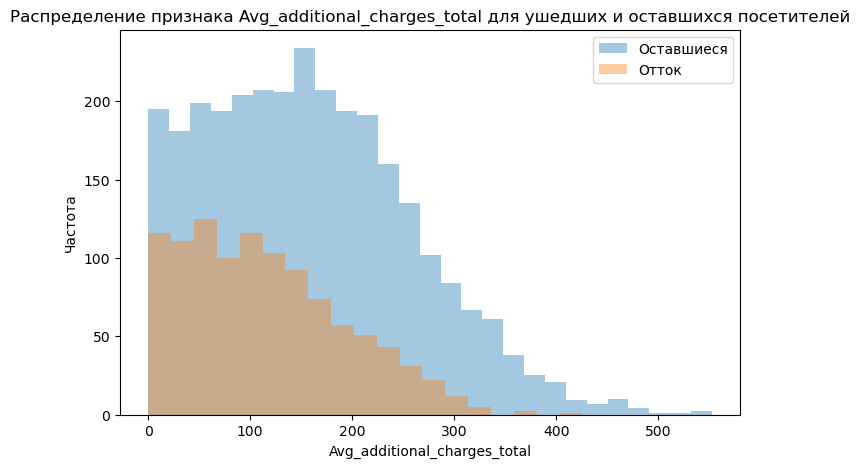

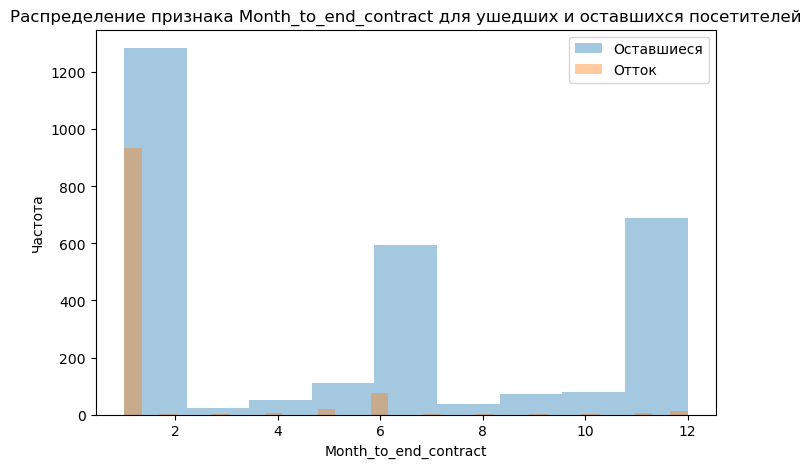

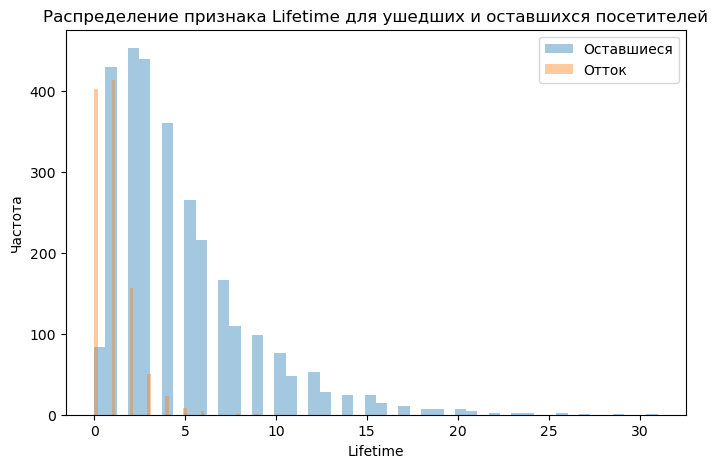

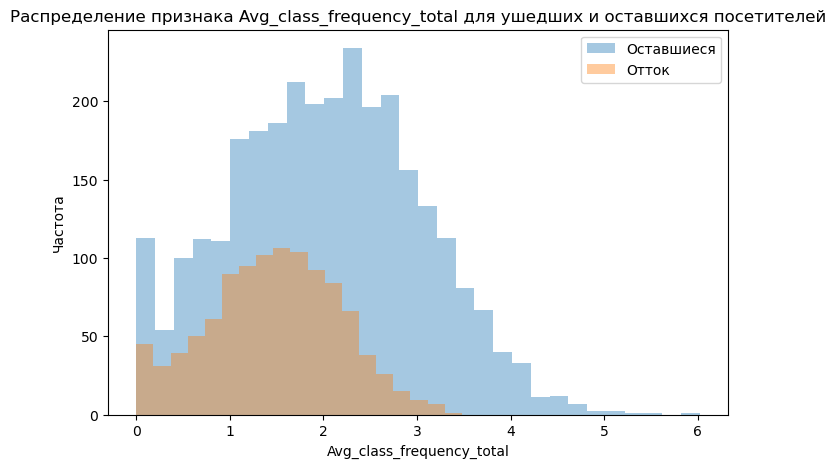

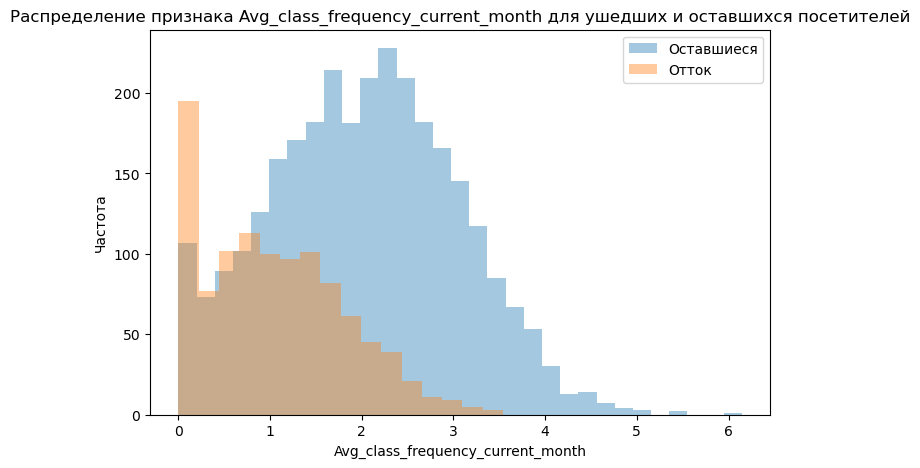

In [17]:
for feature in num_features:
    plt.figure(figsize=(8, 5))
    sns.distplot(data.query('Churn == 0')[feature], label='Оставшиеся', kde=False)
    sns.distplot(data.query('Churn == 1')[feature], label='Отток', kde=False)
    plt.legend()
    plt.title('Распределение признака {} для ушедших и оставшихся посетителей'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

Анализ ушедших и оставшихся клиентов в сравнении друг с другом показывает, что среди оставшихся больше доля партнеров (сотрудники компаний-партнёров клуба), пришедших по акции "приведи друга" и посещающих групповые занятия. Также, у оставшихся клиентов длительность текущего действующего абонемента больше, чем у ушедших (клиенты, не попавшие в отток берут абонемент в среднем на 6 месяцев, а ушедшие на 1 месяц) и оставшиеся в 2 раза чаще посещают клуб (2 раза в неделю, против 1). Посетители попавшие в отток моложе в среднем на 3 года и совершали меньше трат на другие услуги фитнес-центра.

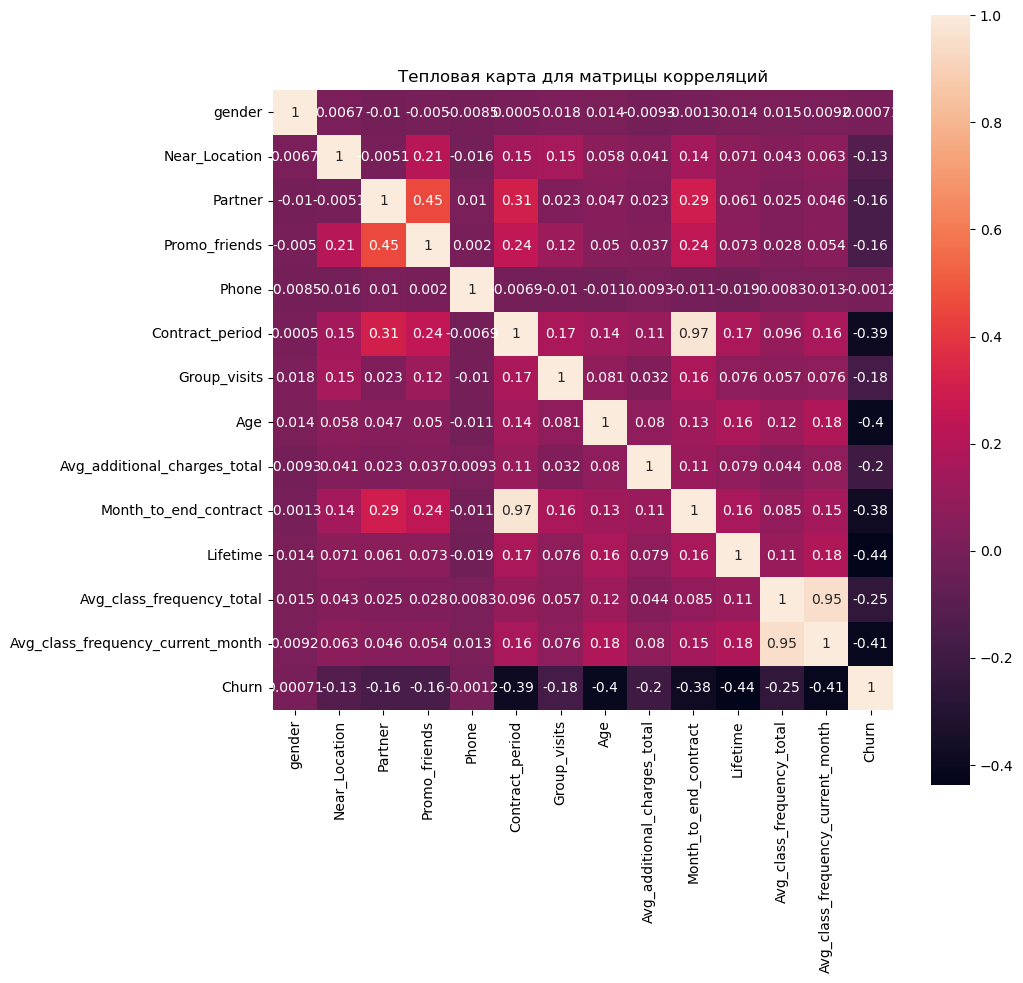

In [16]:
#отображение матрицы корреляций
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, square=True)
plt.title('Тепловая карта для матрицы корреляций')
plt.show()

Согласно матрице корреляций, нет такого признака, который с высокой вероятностью определял бы уйдет клиент или нет. Были обнаружены сильные связи между некоторыми признаками: 
* средняя частота посещений в неделю за все время и средняя частота посещений в неделю за предыдущий месяц (коэффициент корреляции - 0.95)
* длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента (коэффициент корреляции - 0.97)

## Модель прогнозирования оттока клиентов

Построим модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце, с помощью алгоритмов логистической регрессии и случайного леса. Затем, оценим качество построенных моделей с помощью метрик accuracy, precision и recal на валидационной выборке. 

In [16]:
#разделение данных на признаки (матрица X) и целевую переменную (y)
X = data.drop(['Churn'], axis=1)
y = data['Churn']

In [17]:
#разделение данных на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [30]:
#проверка корректности разделения выборок
print(X_train.shape, X_test.shape)

(3200, 13) (800, 13)


In [18]:
#обучение модели на train-выборке методом логистической регрессии
l_model = LogisticRegression(solver='liblinear', random_state=0)
l_model.fit(X_train, y_train)
#прогноз на обученной модели
l_predictions = l_model.predict(X_test)
l_probabilities = l_model.predict_proba(X_test)

In [19]:
#вывод всех метрик
print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, l_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, l_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, l_predictions)))

Метрики для модели логистической регрессии:
Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [20]:
#обучение модели на train-выборке методом случайного леса
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
#прогноз на обученной модели
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)

In [21]:
#вывод всех метрик
print('Метрики для модели случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса:
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Модель логистической регрессии показала себя лучше по всем метрикам. При этом, разница между моделями не значительная. Обе модели правильно прогнозируют более 90% ответов. Метрики точности и полноты принимают значения 0.86 и 0.83, соответственно.

## Кластеризация клиентов

Используя доступную информацию о клиентах, поделим их на группы (кластеры) и выделим их основные свойства.

In [22]:
#стандартиззация данных
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

In [23]:
#запись в переменную матрицы расстояний 
linked = linkage(x_sc, method = 'ward') 

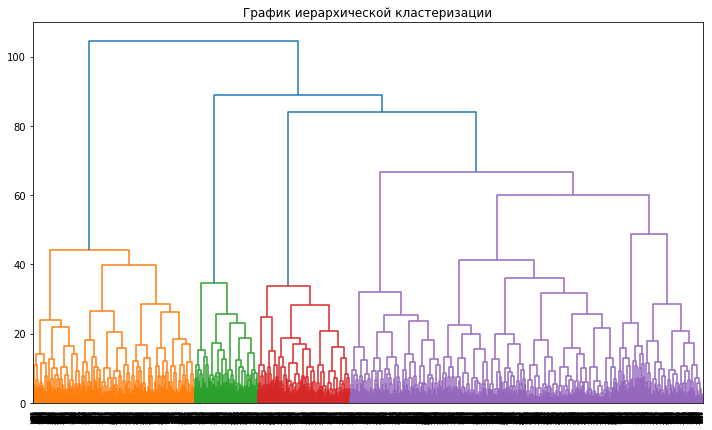

In [24]:
#отрисовка дендрограммы
plt.figure(figsize=(12,7))  
dendrogram(linked, orientation='top')
plt.title('График иерархической кластеризации')
plt.show()

Согласно дендрограмме, предложенное оптимальное число кластеров - 4. Если снизить порог расстояния, можно увеличить число кластеров до 5 или 6. Для решения задачи кластеризации, в дополнение к построенной дендрограмме, запустим алгоритм K-Means (зададим число кластеров n=5).

In [25]:
#применение алгоритма K-Means к стандартизированным данным и формирование вектора кластеров
km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(x_sc)

In [26]:
#запись меток кластера в поле датасета
data['cluster_km'] = labels

In [27]:
print('Численность выделенных групп:')
data['cluster_km'].value_counts()

Численность выделенных групп:


3    1262
0    1010
4     838
2     505
1     385
Name: cluster_km, dtype: int64

In [28]:
#средние значения признаков для кластеров
data.groupby('cluster_km').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


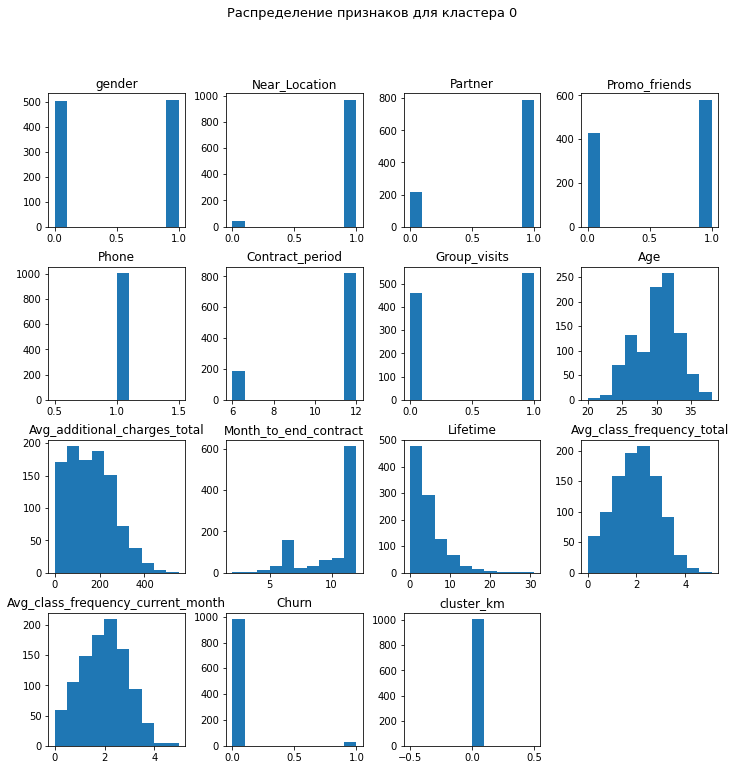

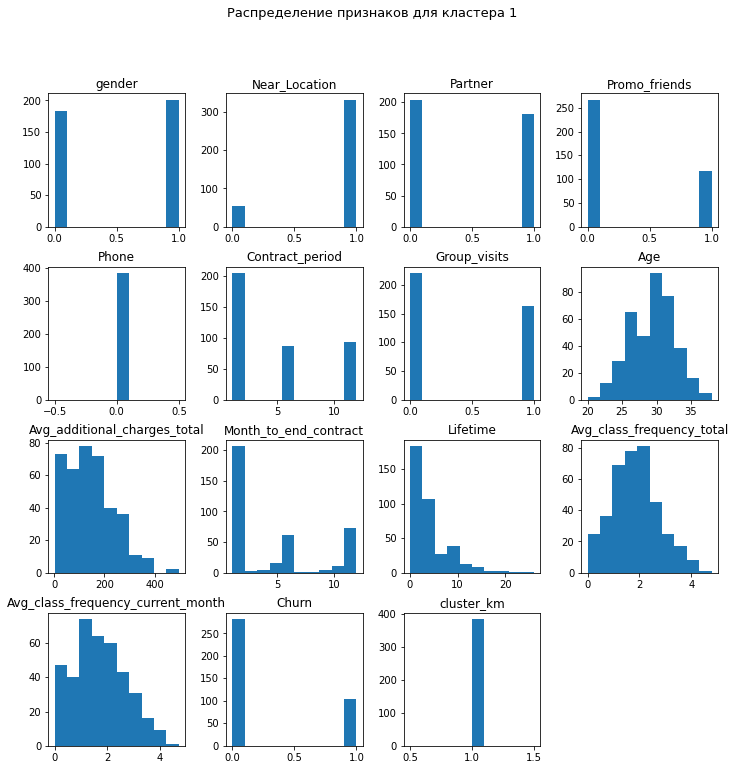

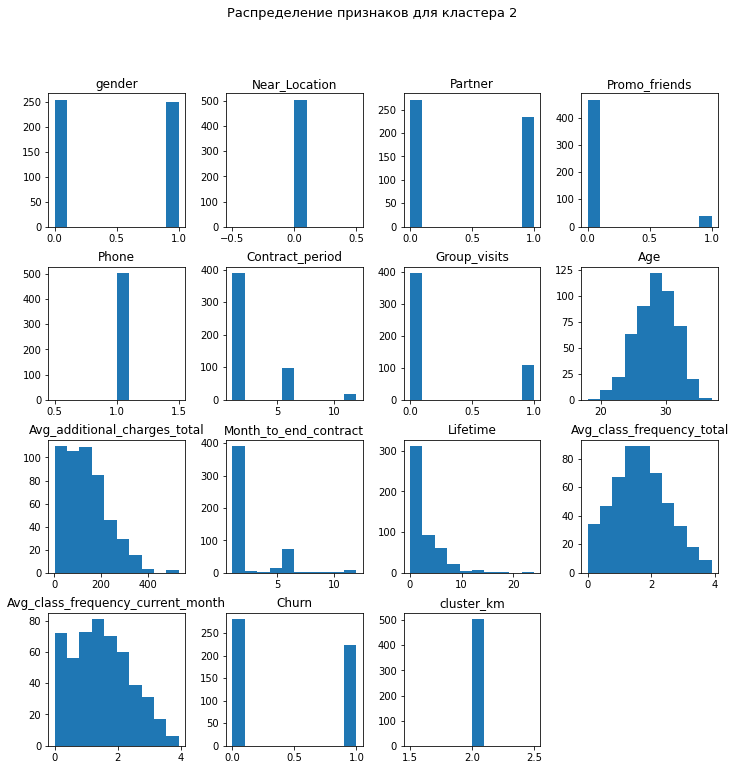

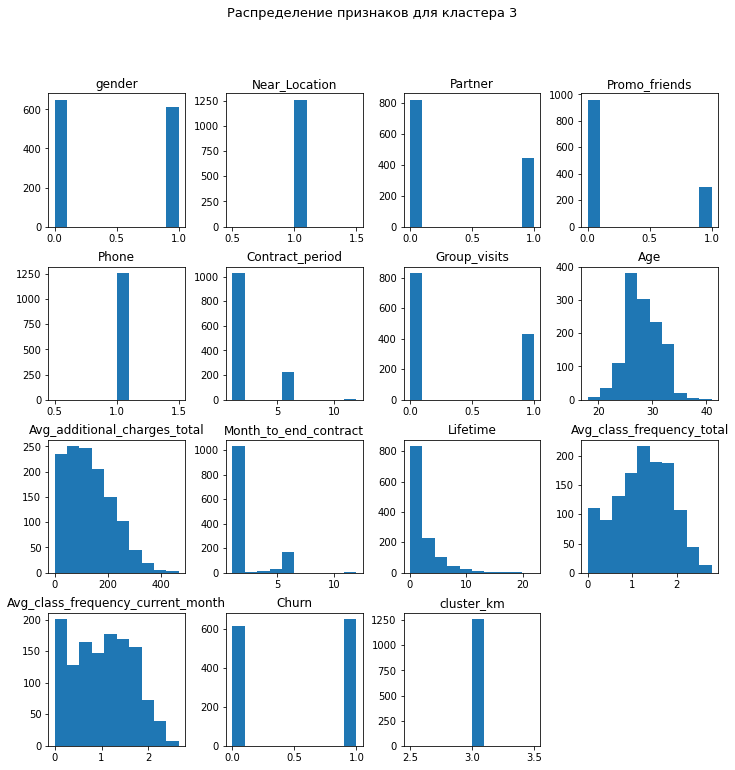

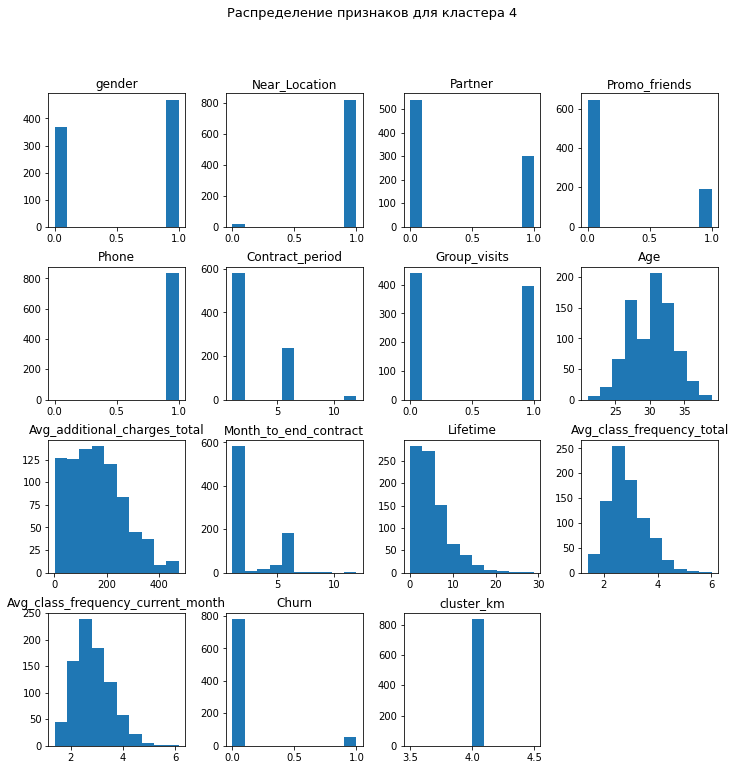

In [29]:
#распределения признаков для кластеров
for cluster in sorted(list(data['cluster_km'].unique())):
    data.query('cluster_km == @cluster').hist(figsize=(12, 12), grid=False)
    plt.suptitle('Распределение признаков для кластера {}'.format(cluster), fontsize=13)
    plt.show()

Рассмотрим характеристики 5-ти выделенных групп:

* 0) Клиенты из 0 категории преимущественно живут или работают рядом с фитнес-центром, являются сотрудниками компании-партнёра клуба; заключают договор с клубом на срок 12 (реже - 6) месяцев; являются членами клуба в среднем около 5 месяцев; средняя частота посещений в неделю - 2; чаще других посещают групповые тренировки; возраст 30-33 года; средняя суммарная выручка от других услуг - 160 рублей; ДОЛЯ ОТТОКА - 0.02.
* 1) Клиенты из 1 категории, также, преимущественно живут или работают рядом с фитнес-центром; большинство заключают договор с клубом на срок 1 месяц (в среднем в группе срок - 5 месяцев); являются членами клуба в среднем около 4 месяцев; средняя частота посещений в неделю - 2; возраста около 30 лет; средняя суммарная выручка от других услуг - 143 рубля; ДОЛЯ ОТТОКА - 0.26.
* 2) Для клиентов из категории 2 характерно проживание или работа вдалеке от фитнес-центра; среди них почти нет участников акции "приведи друга"; большинство заключают договор с клубом на срок 1 месяц; являются членами клуба в среднем около 3 месяцев; посещают клуб 1-2 раза в неделю; реже других посещают групповые тренировки; возраста около 28 лет; средняя суммарная выручка от других услуг - 135 рублей; ДОЛЯ ОТТОКА - 0.44.
* 3) Клиенты из 3 категории живут или работают рядом с фитнес-центром; заключают договор с клубом на срок 1 месяц; являются членами клуба в среднем около 2 месяцев; посещают клуб 1 раз в неделю; возраста около 28 лет; средняя суммарная выручка от других услуг - 131 рубль; ДОЛЯ ОТТОКА - 0.51.
* 4) Большинство клиентов из 4 категории, также, живут или работают рядом с фитнес-центром; заключают договор с клубом преимущественно на срок 1 месяц (в среднем в группе срок - 3 месяца); являются членами клуба в среднем около 5 месяцев; посещают клуб 2-3 раза в неделю; возраста около 30 лет; средняя суммарная выручка от других услуг - 161 рубль; ДОЛЯ ОТТОКА - 0.06.

## Выводы и рекомендации

По итогам работы с данными о клиентах фитнес-центров была выбрана и построена модель прогноза оттока клиентов с помощью алгоритма логистической регрессии, а также, выделены 5 целевых групп клиентов.

Больше всего доля оттока клиентов в группах с индексами 2 и 3 (44% и 51%, соответственно). Эти клиенты не склонны заключать договор на длительный срок, пришли не по акции "приведи друга", реже других посещают клуб и групповые занятия, меньше тратят на другие услуги фитнес-центра. 

На основе анализа данных групп риска и групп с наименьшей долей оттока, предложены следующие рекомендации: 
* Продвижение групповых тренировок - в группах с наименьшим оттоком наибольшая доля посещающих групповые тренировки.
* Работа над расширением/ повышением качества других услуг фитнес-центра - предположительно, чем интересней будут клиенту предложения клуба (помимо тренировок), которыми он будет пользоваться, тем выше посещаемость и ниже вероятность ухода.
* Работа с клиентами на 2-3 месяце членства в клубе - лайфтайм групп с высокой долей оттока составляет 2-3 месяца, это месяц принятия решения о прекращении посещения фитнес-центра. Таким образом, клиентам на 2-3 месяце могут быть предложены различные "удерживающие" акции, специальные условия или бонусы.